In [1]:
# Modif target_binary, ignore_column for next participant ????????????????????????????
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A0/converted/trialinfo_matrix_A0_cleanedtrials.mat'
data_file = '/data/A0/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_0.fif'

relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz']
electrodes_kabir = ['POz', 'PO3', 'PO4', 'Pz', 'P1', 'P3', 'Oz', 'O1', 'O2']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import copy
from collections import Counter


In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']


# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_0.fif ...


/tmp/ipykernel_15575/719731429.py:23: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_0.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,440
Events,1: 440
Time range,-1.000 – 2.299 s
Baseline,off


In [5]:
# Keep only trials where there was no target
epochs = epochs['target_binary==0']

# A. Frequency tagging condition
# 1 - Tag presence
## 1.1 FFT & SNR

In [6]:
epochs_freqtag = epochs['tagging_type==0'].copy()

# Simplify metadata
epochs_freqtag.metadata['flicker_sides'] = epochs_freqtag.metadata['flicker_sides'].replace({0: 6056, 1: 5660})
epochs_freqtag.metadata['cued_side'] = epochs_freqtag.metadata['cued_side'].replace({0: 'left', 1: 'right'})

condition_1 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'left')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'right'))
condition_2 = ((epochs_freqtag.metadata['flicker_sides'] == 6056.0) & (epochs_freqtag.metadata['cued_side'] == 'right')) | \
    ((epochs_freqtag.metadata['flicker_sides'] == 5660.0) & (epochs_freqtag.metadata['cued_side'] == 'left'))
epochs_freqtag.metadata['cued_tag'] = np.where(condition_1, 60, np.where(condition_2, 56, np.nan))

SNR at 56Hz: 1.8114906748282147
SNR at 60Hz: 2.396638528094133


/tmp/ipykernel_15575/26133340.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


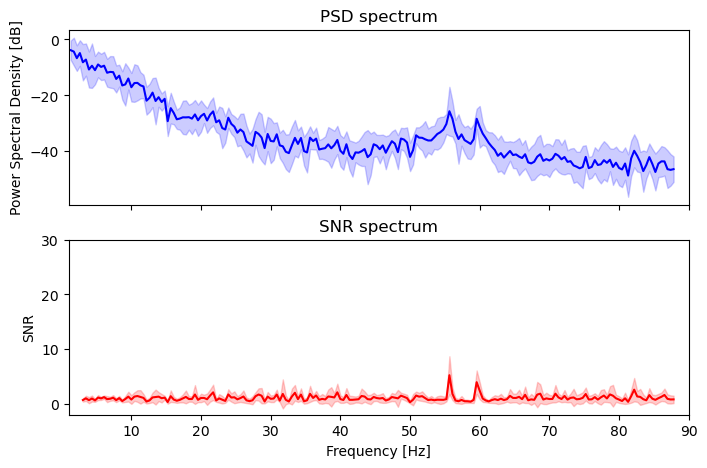

In [7]:
# Fast Fourier Transform
# adapted from https://mne.tools/dev/auto_tutorials/time-freq/50_ssvep.html

sfreq = epochs_freqtag.info["sfreq"]
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90

# Spectrum of the signal averaged over trials
spectrum = epochs_freqtag.copy().average().compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="hamming",
    verbose=False,
)
psds, freqs_psd = spectrum.get_data(return_freqs=True)

# Signal to noise ratio (Meigen & Bach (1999))

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.
    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

# Get bins to exlude from regularization (close neighbors ±0.5Hz)  
bin_size = np.diff(freqs_psd)[0]
skip_nei = int((0.5 - bin_size/2)//bin_size) 

# Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]

snrs = snr_spectrum(psds, noise_n_neighbor_freqs = used_nei, noise_skip_neighbor_freqs = skip_nei)


%matplotlib inline
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs_psd) == 1.0)[0][0], np.where(np.ceil(freqs_psd) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0))[freq_range]
psds_std = psds_plot.std(axis=(0))[freq_range]
axes[0].plot(freqs_psd[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs_psd[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0))[freq_range]
snr_std = snrs.std(axis=(0))[freq_range]

axes[1].plot(freqs_psd[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs_psd[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

# Extract SNR values at the stimulation frequency
stim_freq1 = 56
stim_freq2 = 60

# find index of frequency bin closest to stimulation frequency
i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

# Apply the subset
snrs_target1 = snrs[:, i_bin_1]
snrs_target2 = snrs[:, i_bin_2]
print(f'SNR at {stim_freq1}Hz: {snrs_target1.mean()}')
print(f'SNR at {stim_freq2}Hz: {snrs_target2.mean()}')


In [8]:
snrs_df = pd.DataFrame(snrs)
snrs_df['electrode'] = epochs_freqtag.info['ch_names']
snrs_df = snrs_df.melt(id_vars='electrode')
snrs_df['frequency'] = freqs_psd[snrs_df.variable.values.astype(int)]
snrs_df.to_csv('files/A0_snrs.csv',index=False)
snrs_df

,electrode,variable,value,frequency
0,O2,0,NaN,1.304459
1,PO4,0,NaN,1.304459
2,PO8,0,NaN,1.304459
3,P8,0,NaN,1.304459
4,P4,0,NaN,1.304459
...,...,...,...,...
3667,O1,203,NaN,89.572824
3668,Pz,203,NaN,89.572824
3669,POz,203,NaN,89.572824
3670,Oz,203,NaN,89.572824


## 1.2 Topography of the SNR

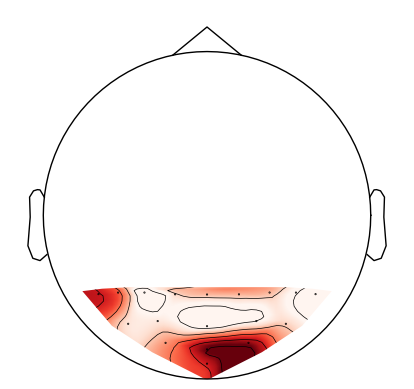

/tmp/ipykernel_15575/1146432722.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


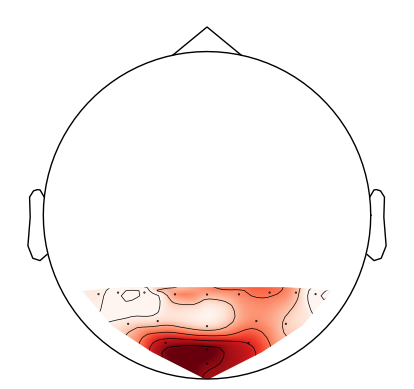

Channels with highest SNR for 56Hz['Oz' 'O2' 'Iz' 'P7' 'P5' 'O1']
Channels with highest SNR for 60Hz['Oz' 'Iz' 'O1' 'O2' 'P4' 'P2']


/tmp/ipykernel_15575/1146432722.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [9]:
# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target1, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_target2, epochs.info, vlim=(1, None), axes=ax, extrapolate='local')
fig.show()

# Channels with the highest SNR 
print(f'Channels with highest SNR for 56Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:6]}')
print(f'Channels with highest SNR for 60Hz{np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:6]}')


#select electrodes from 56 as the top electrodes are parietal and occipital
SNR_best_electrodes_56 = np.array(epochs.info['ch_names'])[np.argsort(snrs_target1)[::-1]][:6]
SNR_best_electrodes_60 = np.array(epochs.info['ch_names'])[np.argsort(snrs_target2)[::-1]][:6]

## 1.3 Time frequency analysis of coherence by electrode
Coherence is studied in the time window between trial start and onset of the stimuli (the post stimuli window is likely contaminated by attentional catching due to their onset).

In [10]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(53, 70, step = 0.5)

### Magnitude squared coherence with Hilbert transform

Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


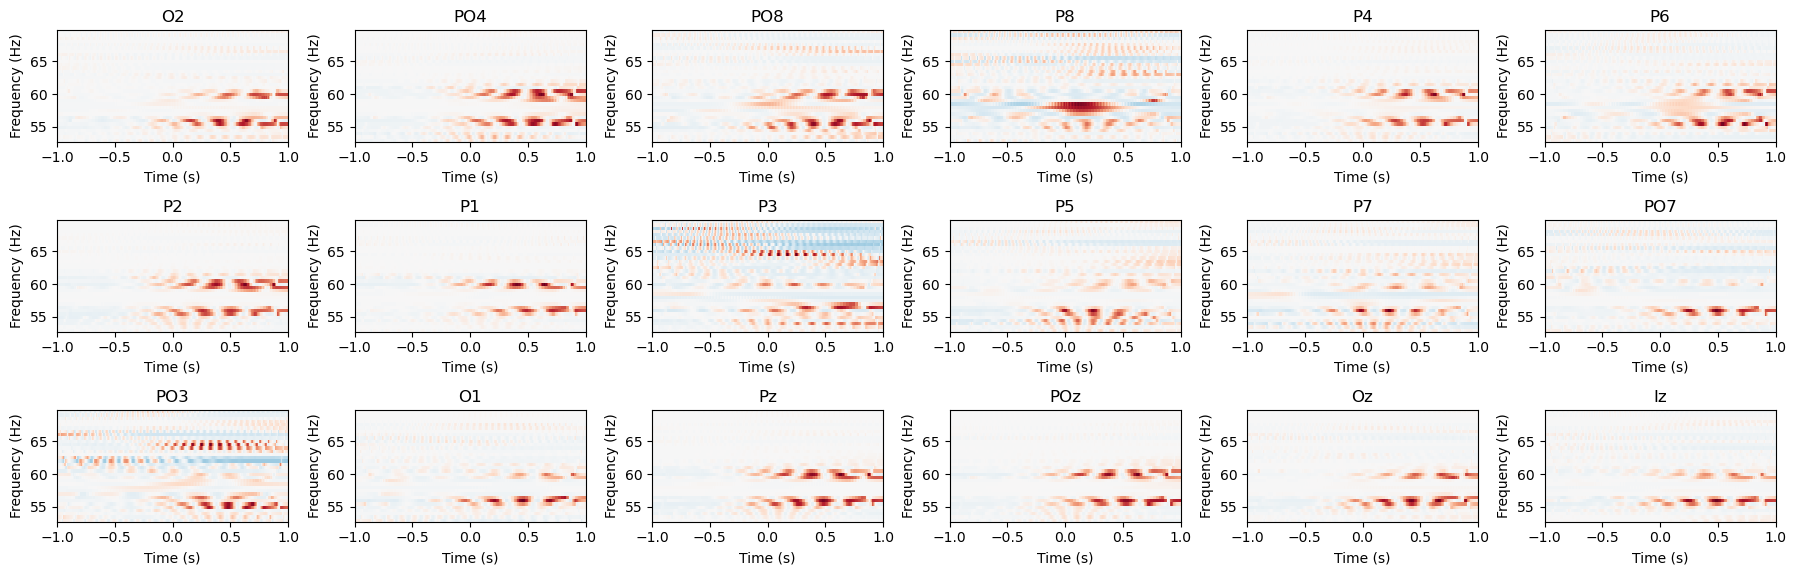

From best to 5th 
Channels with the highest coherence with 56:['Pz' 'POz' 'P2' 'PO4' 'P1' 'Oz']                         
Channels with the highest coherence with 60:['Pz' 'POz' 'P2' 'PO4' 'P1' 'P4']


In [11]:
def coherence_kabir(signalX, pick, freq_of_interest):

    #get info from EEG
    min_time = signalX.times[0]
    max_time = signalX.times[-1]
    sampling_rate = signalX.info['sfreq']
    
    # Band-pass EEG (+/-1.9Hz) and apply hilbert
    signalX = signalX.copy().pick(pick).filter(l_freq=freq_of_interest - .5, h_freq=freq_of_interest + .5,
        method='iir', iir_params=dict(order=4, ftype='butter'), phase='zero', fir_window='hamming', verbose = False)
    #filter(l_freq = freq_of_interest - 1.9, h_freq = freq_of_interest + 1.9, verbose=True)
    
    signalX = np.squeeze(signalX.get_data(copy=False)).T
    signalXh =  scipy.signal.hilbert(signalX, axis=1)
    n = signalXh.shape[1]  # number of trials

    #Create sine wave
    t = np.linspace(min_time, max_time, int(sampling_rate * (np.abs(min_time) + max_time))+1, endpoint=False)
    signalY = np.sin(2 * np.pi * freq_of_interest * t)
    signalY = np.tile(signalY, (n,1)).T #repeat over trials
    # Hilbert transform
    signalYh = scipy.signal.hilbert(signalY.T, axis=1)

    # Magnitude
    mX = np.abs(signalXh).T
    mY = np.abs(signalYh)

    # Phase difference
    phase_diff = np.angle(signalXh).T - np.angle(signalYh)

    coh = np.zeros(signalY.shape[0])
    for t in range(signalY.shape[0]):
        num = ((np.abs(np.sum(mX[:, t] * mY[:, t] * np.exp(1j * phase_diff[:, t])) / n)) ** 2)
        denom = (np.sum((mX[:, t]**2) * (mY[:, t]**2)) / n)
        coh[t] = num/denom
        
    return coh

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(53, 70, step = 0.5)

channels = epochs_freqtag.info['ch_names']

epochs_freqtag_cropped = epochs_freqtag.copy().crop(tmin, tmax)

coherence_mat = np.zeros((len(channels), freqs.size, len(epochs_freqtag_cropped.times)))

for e, channel in enumerate(channels):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_freqtag_cropped, [channel], freq)

coherence_hilbert = mne.time_frequency.EpochsTFRArray(epochs_freqtag_cropped.info, np.array([coherence_mat]), epochs_freqtag_cropped.times, freqs)

# Baseline (-1 to 0s) correction
coherence_hilbert = coherence_hilbert.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(3, 6, figsize=(18, 6))  
axes = axes.flatten() 

# Plot each channel
for e, (channel, ax) in enumerate(zip(channels, axes)):
    coherence_hilbert.plot(
        picks=[channel],
        baseline= None,
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel)  

plt.tight_layout()
plt.show()



# Channels with the highest coherence with the cued frequency
print(f'From best to 5th \nChannels with the highest coherence with 56:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 56),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]}')
best_electrodes_coherence_56 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 56),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(coherence_mat[:,np.where(freqs == 60),:].max(axis = -1)))[::-1]][:6]

### Inter-trial coherence with Morlet estimation

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   20.9s


Applying baseline correction (mode: mean)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


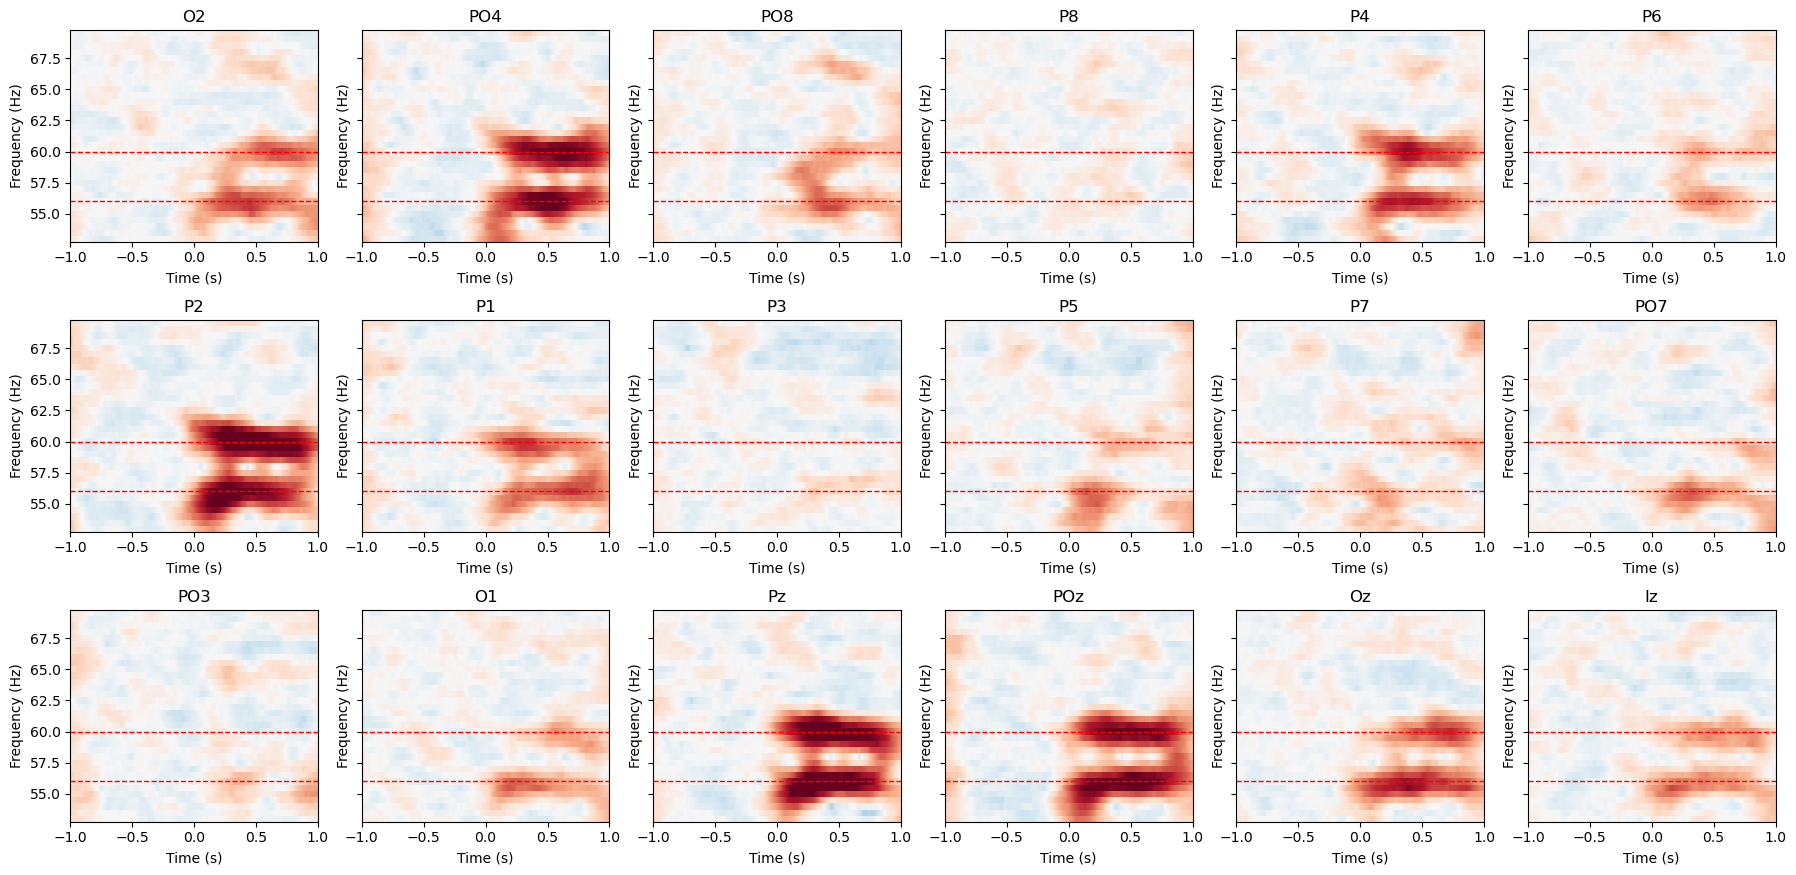

Frequencies with the maximum coherence in descending order : [56.  55.5 60.  56.5]
From best to 6th 
Channels with the highest coherence with 60:['Pz' 'P2' 'POz' 'PO4' 'P4' 'Oz']                         
Channels with the highest coherence with 56:['Pz' 'P2' 'POz' 'PO4' 'Oz' 'P4']


In [12]:
# n_cylce: trade-off temporal vs frequency resolution (is how many cycles of the frequency to include in the Gaussian envelope). 
# Frequency resolution is emphasized.

# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.arange(53, 70, step = 0.5)

_, itc = epochs_freqtag.copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs, n_cycles=freqs, return_itc=True, average=True
)

# Baseline (-1 to 0s) correction
itc = itc.apply_baseline(baseline=(tmin, 0))

fig, axes = plt.subplots(3, 6, figsize=(18, 9), sharey = True) 
axes = axes.flatten() 

channels = epochs_freqtag.info['ch_names']

# Plot each electrode
for e, (channel, ax) in enumerate(zip(channels, axes)):
    itc.plot(
        picks=[channel],
        baseline=None,
        vlim=(-.4, .4),
        axes=ax,
        colorbar=False,
        show=False 
    )
    ax.set_title(channel) 
    ax.axhline(y=56, color='r', linestyle='--', linewidth=1)
    ax.axhline(y=60, color='r', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()

# Check whether the expected frequencies are indeed the highest
itc_arr, frex_idx = itc.get_data(return_freqs=True)
print(f'Frequencies with the maximum coherence in descending order : {frex_idx[itc_arr.mean(axis=(0,2)).argsort()[::-1]][:4]}')

print(f'From best to 6th \nChannels with the highest coherence with 60:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]} \
                        \nChannels with the highest coherence with 56:{np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==56),:].max(axis = -1)))[::-1]][:6]}')

best_electrodes_coherence_morlet_56 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==56),:].max(axis = -1)))[::-1]][:6]
best_electrodes_coherence_morlet_60 = np.array(epochs.info['ch_names'])[np.argsort(np.squeeze(itc_arr[:,np.where(frex_idx==60),:].max(axis = -1)))[::-1]][:6]

## 1.4 Select electrodes based on previous analysis

In [13]:
print(f'Top 6 electrodes for SNR 56{SNR_best_electrodes_56}')
print(f'Top 6 electrodes for SNR 60{SNR_best_electrodes_60}')
print(f'Top 6 electrodes for Coherence 56 {best_electrodes_coherence_56}')
print(f'Top 6 electrodes for Coherence 60 {best_electrodes_coherence_60}')
print(f'Top 6 electrodes for ITC Morlet 56 {best_electrodes_coherence_morlet_56}')
print(f'Top 6 electrodes for ITC Morlet 60 {best_electrodes_coherence_morlet_60}')

Top 6 electrodes for SNR 56['Oz' 'O2' 'Iz' 'P7' 'P5' 'O1']
Top 6 electrodes for SNR 60['Oz' 'Iz' 'O1' 'O2' 'P4' 'P2']
Top 6 electrodes for Coherence 56 ['Pz' 'POz' 'P2' 'PO4' 'P1' 'Oz']
Top 6 electrodes for Coherence 60 ['Pz' 'POz' 'P2' 'PO4' 'P1' 'P4']
Top 6 electrodes for ITC Morlet 56 ['Pz' 'P2' 'POz' 'PO4' 'Oz' 'P4']
Top 6 electrodes for ITC Morlet 60 ['Pz' 'P2' 'POz' 'PO4' 'P4' 'Oz']


In [14]:
# Select top 6 electrodes that are the most often the best according to SNR, IT coherence and MS coherence
all_electrodes = (list(SNR_best_electrodes_56) + 
                  list(SNR_best_electrodes_60) + 
                  list(best_electrodes_coherence_56) + 
                  list(best_electrodes_coherence_60) + 
                  list(best_electrodes_coherence_morlet_56) + 
                  list(best_electrodes_coherence_morlet_60))

# Count the occurrences of each electrode
electrode_counts = Counter(all_electrodes)

best_electrodes = [electrode for electrode, count in electrode_counts.most_common(6)]

print(f'selected electrodes: {best_electrodes}')

selected electrodes: ['Oz', 'P2', 'P4', 'Pz', 'POz', 'PO4']


# 2 - Testing for an attentional effect
### Comparing SNR across cued conditions

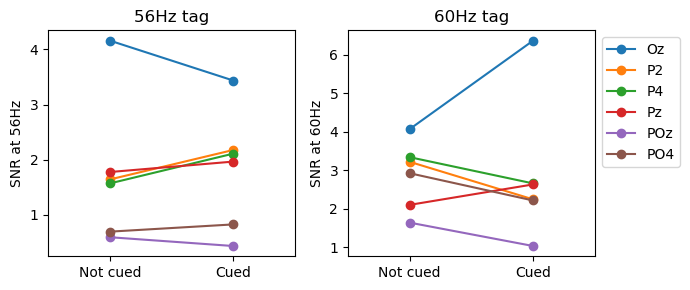

In [15]:
queries = ["cued_tag == 56", "cued_tag == 60"]
vals = {}
stim_freq1 = 56
stim_freq2 = 60

sfreq = epochs_freqtag.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_freqtag[query].copy().pick(best_electrodes).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)
    bin_size = np.diff(freqs_psd)[0]
    # Get bins to exlude from regularization (close neighbors ±0.5Hz)  
    bin_size = np.diff(freqs_psd)[0]
    skip_nei = int((0.5 - bin_size/2)//bin_size) 
    
    # Get bins to include in regularization (neighbors within +/- 2-0.5Hz)
    used_nei = int((2 - bin_size/2) // bin_size)  # Total bins within ±2 Hz
    used_nei = used_nei - skip_nei # Bins within (0.5 Hz, 2 Hz]
    
    snrs = snr_spectrum(psds, noise_n_neighbor_freqs = used_nei, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))

    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(snrs[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(snrs[:, i_bin_2])

fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(best_electrodes):
    ax[0].plot([0,1], [vals['56cued_tag == 60'][e], vals['56cued_tag == 56'][e]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['60cued_tag == 56'][e], vals['60cued_tag == 60'][e]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 56Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 60Hz')
ax[0].set_title('56Hz tag')
ax[1].set_title('60Hz tag')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

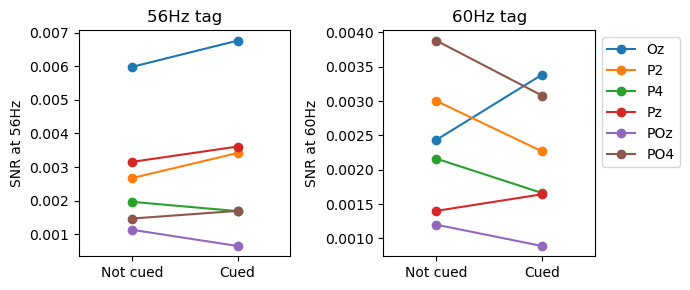

In [16]:
## TEST direct sur PSD ??
queries = ["cued_tag == 56", "cued_tag == 60"]
vals = {}
stim_freq1 = 56
stim_freq2 = 60

sfreq = epochs_freqtag.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_freqtag[query].copy().pick(best_electrodes).average().compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)
    # bin_size = np.diff(freqs_psd)[0]
    # skip_nei = int((2 - bin_size/2)//bin_size)
    # snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(psds[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(psds[:, i_bin_2])

fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(best_electrodes):
    ax[0].plot([0,1], [vals['56cued_tag == 60'][e], vals['56cued_tag == 56'][e]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['60cued_tag == 56'][e], vals['60cued_tag == 60'][e]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 56Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 60Hz')
ax[0].set_title('56Hz tag')
ax[1].set_title('60Hz tag')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

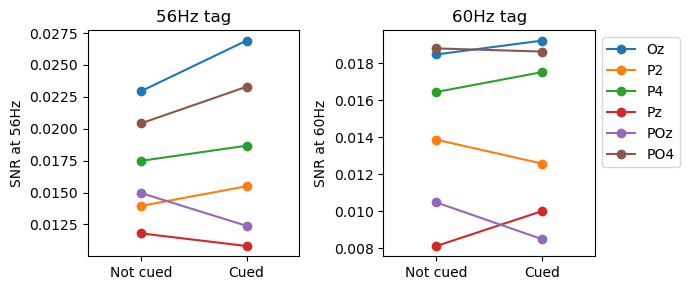

In [34]:
## TEST direct sur PSD par essai
queries = ["cued_tag == 56", "cued_tag == 60"]
vals = {}
stim_freq1 = 56
stim_freq2 = 60

sfreq = epochs_freqtag.info['sfreq']
tmin = 0 # Search in window starting from cue (when SSVEP is expected)
tmax = 2.3
fmin = 1.0
fmax = 90.0

for query in queries:
    # Spectrum averaged over all trials
    spectrum = epochs_freqtag[query].copy().pick(best_electrodes).compute_psd(
        "welch",
        n_fft=int(sfreq * (tmax - tmin)),
        n_overlap=0,
        n_per_seg=None,
        tmin=tmin,
        tmax=tmax,
        fmin=fmin,
        fmax=fmax,
        window="hamming",
        verbose=False,
    )
    psds, freqs_psd = spectrum.get_data(return_freqs=True)
    psds = psds.mean(axis=0)
    # bin_size = np.diff(freqs_psd)[0]
    # skip_nei = int((2 - bin_size/2)//bin_size)
    # snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs = skip_nei)

    # find index of frequency bin closest to stimulation frequency
    i_bin_1 = np.argmin(abs(freqs_psd - stim_freq1))
    i_bin_2 = np.argmin(abs(freqs_psd - stim_freq2))
    
    # Apply the subset
    vals[str(int(stim_freq1))+query] = copy.deepcopy(psds[:, i_bin_1])
    vals[str(int(stim_freq2))+query] = copy.deepcopy(psds[:, i_bin_2])

fig, ax = plt.subplots(1,2, figsize=(7,3), sharex=False)
for e, elec in enumerate(best_electrodes):
    ax[0].plot([0,1], [vals['56cued_tag == 60'][e], vals['56cued_tag == 56'][e]], 'o-', label=elec)
    ax[1].plot([0,1], [vals['60cued_tag == 56'][e], vals['60cued_tag == 60'][e]], 'o-', label=elec)

ax[0].set_ylabel('SNR at 56Hz')
ax[0].set_xticks([0,1], ['Not cued', 'Cued'])
ax[0].set_xlim(-.5, 1.5)
ax[1].set_xlim(-.5, 1.5)
ax[1].set_xticks([0,1], ['Not cued', 'Cued'])
ax[1].set_ylabel('SNR at 60Hz')
ax[0].set_title('56Hz tag')
ax[1].set_title('60Hz tag')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [17]:
snr_df = pd.DataFrame(vals)
snr_df['electrode'] = best_electrodes
snr_df = snr_df.melt(id_vars='electrode')
snr_df[['freq', 'cued']] = snr_df['variable'].str.split('cued_tag == ', expand=True)
snr_df = snr_df.drop('variable', axis=1)
snr_df.to_csv('files/A0_snr.csv',index=False)

### Comparing inter-trial coherence across cued conditions

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


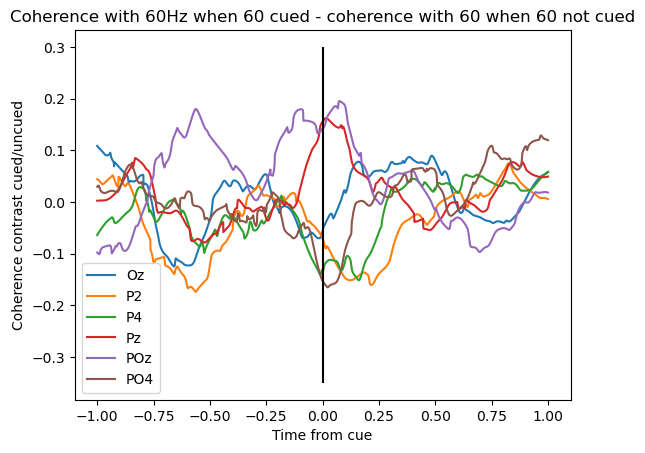

Text(0, 0.5, 'Coherence contrast cued/uncued')

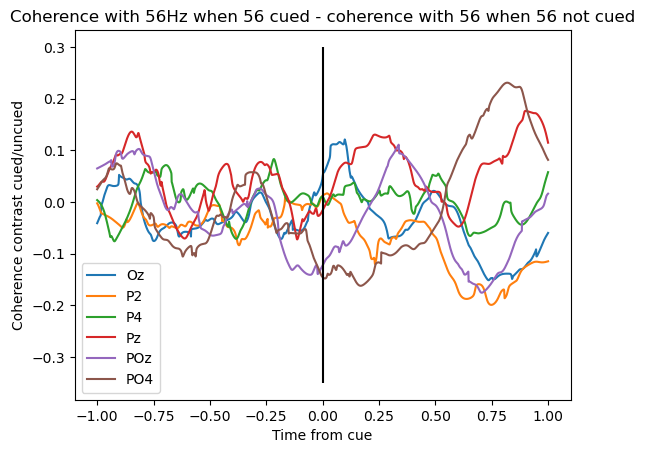

In [18]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1

# Get inter-trial coherence with 56 and 60Hz by cued frequency 
freqs5660 = [56, 60]
_, itc_60 = epochs_freqtag['cued_tag == 60'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs5660, n_cycles=np.array(freqs5660), return_itc=True, average=True
)

_, itc_56 = epochs_freqtag['cued_tag == 56'].copy().crop(tmin, tmax).compute_tfr(
    method="morlet", freqs=freqs5660, n_cycles=np.array(freqs5660), return_itc=True, average=True
)

itc_60_arr, times_coh, freqs_idx = itc_60.get_data(return_freqs = True, return_times = True)
itc_56_arr = itc_56.get_data()

elec_idx = np.where(np.isin(epochs.info['ch_names'], best_electrodes))[0]

coherence = {}
coherence['with60_for60cued'] = itc_60_arr[elec_idx,1,:]
coherence['with56_for60cued'] = itc_60_arr[elec_idx,0,:]
coherence['with60_for56cued'] = itc_56_arr[elec_idx,1,:]
coherence['with56_for56cued'] = itc_56_arr[elec_idx,0,:]

plt.plot(times_coh, coherence['with60_for60cued'].T - coherence['with60_for56cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')
plt.show()

plt.plot(times_coh, coherence['with56_for56cued'].T - coherence['with56_for60cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 56Hz when 56 cued - coherence with 56 when 56 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')

????? il semble qu il n y ait d effet attentionnel. En meme t il ne pouvait pas y avoir de target avant 1s et c etait sur car meme pas les gabor presents.

In [19]:
# Export for group analysis

def pd_coh(coherence_dic, cued, coh_with):
    coherence = pd.DataFrame(coherence_dic[f'with{coh_with}_for{cued}cued'])
    coherence['channel'] = best_electrodes
    coherence['cued'] = cued
    coherence['coh_with'] = coh_with
    coherence = coherence.melt(id_vars=['channel','cued','coh_with'])
    coherence['time'] = coherence['variable']*(1/epochs_freqtag.info['sfreq']) + tmin
    return coherence

coh60_cue60 = pd_coh(coherence, 60, 60)
coh60_cue56 = pd_coh(coherence, 56, 60)
coh56_cue60 = pd_coh(coherence, 60, 56)
coh56_cue56 = pd_coh(coherence, 56, 56)

ITcoh_A0 = pd.concat([coh56_cue56, coh56_cue60, coh60_cue56, coh60_cue60])
ITcoh_A0.columns = ['channel', 'cued', 'coh_with', 'timepoint', 'ITcoherence', 'time']
ITcoh_A0.to_csv('files/ITcoh_A0.csv',index=False)

### Comparing MS coherence across cued conditions

In [20]:
# time window from -1 sec to 1 sec relative to cue
tmin, tmax = -1, 1
# Define range of frequencies of interest
freqs = np.array([56, 60])

epochs_freqtag_cropped = epochs_freqtag['cued_tag == 60'].copy().pick(best_electrodes).crop(tmin, tmax)
coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_freqtag_cropped.times)))
for e, channel in enumerate(best_electrodes):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_freqtag_cropped, [channel], freq)
coherence_hilbert_60 = mne.time_frequency.EpochsTFRArray(epochs_freqtag_cropped.info, np.array([coherence_mat]), epochs_freqtag_cropped.times, freqs)

epochs_freqtag_cropped = epochs_freqtag['cued_tag == 56'].copy().pick(best_electrodes).crop(tmin, tmax)
coherence_mat = np.zeros((len(best_electrodes), freqs.size, len(epochs_freqtag_cropped.times)))
for e, channel in enumerate(best_electrodes):
    for i, freq in enumerate(freqs):
        coherence_mat[e,i,:] = coherence_kabir(epochs_freqtag_cropped, [channel], freq)
coherence_hilbert_56 = mne.time_frequency.EpochsTFRArray(epochs_freqtag_cropped.info, np.array([coherence_mat]), epochs_freqtag_cropped.times, freqs)

coherence_hilbert_60, times_coh, freqs_idx = coherence_hilbert_60.get_data(return_freqs = True, return_times = True)
coherence_hilbert_56 = coherence_hilbert_56.get_data()

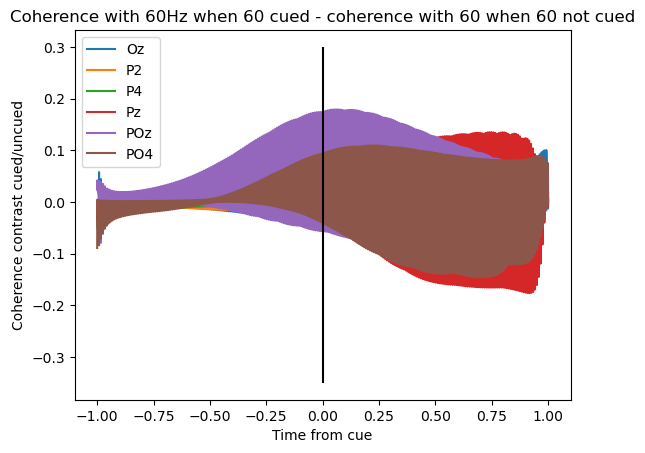

Text(0, 0.5, 'Coherence contrast cued/uncued')

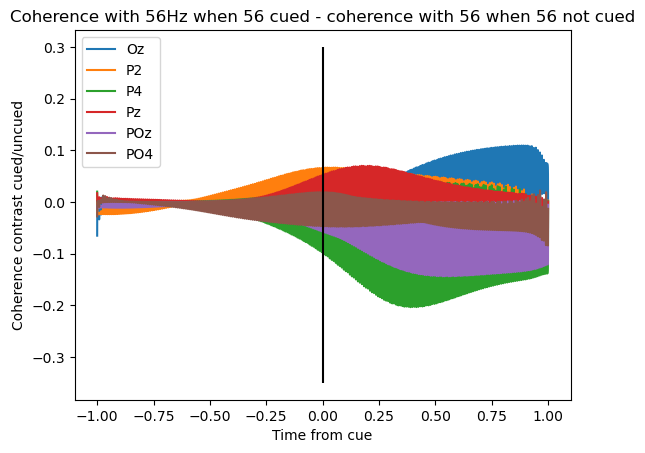

In [21]:
coherence_hilbert = {}
coherence_hilbert['with60_for60cued'] = np.squeeze(coherence_hilbert_60)[:,1,:]
coherence_hilbert['with56_for60cued'] = np.squeeze(coherence_hilbert_60)[:,0,:]
coherence_hilbert['with60_for56cued'] = np.squeeze(coherence_hilbert_56)[:,1,:]
coherence_hilbert['with56_for56cued'] = np.squeeze(coherence_hilbert_56)[:,0,:]

plt.plot(times_coh, coherence_hilbert['with60_for60cued'].T - coherence_hilbert['with60_for56cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 60Hz when 60 cued - coherence with 60 when 60 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')
plt.show()

plt.plot(times_coh, coherence_hilbert['with56_for56cued'].T - coherence_hilbert['with56_for60cued'].T, label = best_electrodes)
plt.vlines(0,-0.35,0.3, color = 'black')
plt.legend()
plt.title('Coherence with 56Hz when 56 cued - coherence with 56 when 56 not cued')
plt.xlabel('Time from cue')
plt.ylabel('Coherence contrast cued/uncued')

In [22]:
# Export for group analysis
coh60_cue60 = pd_coh(coherence_hilbert, 60, 60)
coh60_cue56 = pd_coh(coherence_hilbert, 56, 60)
coh56_cue60 = pd_coh(coherence_hilbert, 60, 56)
coh56_cue56 = pd_coh(coherence_hilbert, 56, 56)

MScoh_A0 = pd.concat([coh56_cue56, coh56_cue60, coh60_cue56, coh60_cue60])
MScoh_A0.columns = ['channel', 'cued', 'coh_with', 'timepoint', 'MScoherence', 'time']
MScoh_A0.to_csv('files/MScoh_A0.csv',index=False)

# B. Noise tagging condition
# 1 - Tag presence
## 1.1 Cross-correlation

In [23]:
epochs_noistag = epochs['tagging_type==1'].copy()

f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

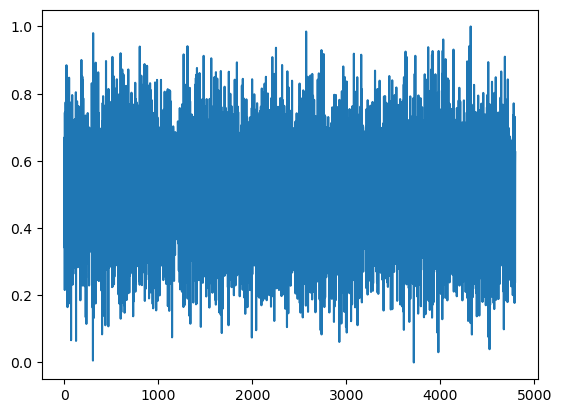

In [24]:
# First noise tag at block 15 trial 32
plt.plot(noise_stims[14,31,0,:].T)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [25]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [26]:
noise_stims_tr.shape

(480, 2, 4800)

In [27]:
# Get cross-correlation 
def cross_cor_nois(epochs_fun, noise, display_side_cued_tag, sampling_freq, electrodes=None,
                  tmin_eeg=0, tmax_eeg=1, tmin_noise=0, tmax_noise=1):
    '''
    noise_tags : array trial*tag*timepoint
    display_side_cued_tag : 'left' or 'right'
    sampling_freq : 1920 or 480(Hz)
    tmin_noise : >=0
    
    Returns 2 matrices (trial*electrode*lag (in time steps between EEG start and tag start) of corr values. 
    The first matrice contains the EEG/cued_tag corr, the second the EEG/tag2 corr
    '''
    display_side_cued_tag = 0 if display_side_cued_tag == 'left' else \
        (1 if display_side_cued_tag == 'right' else ValueError("Invalid value for display_side_cued_tag"))

    # Select elec
    if electrodes is None : 
        eeg = epochs_fun.copy()
    else : eeg = epochs_fun.copy().pick(electrodes)
    noise_tags = copy.deepcopy(noise)
    # Converge EEG and tag sampling frequencies 
    if sampling_freq == 1920:
            eeg.resample(sfreq = sampling_freq)
            # Upsample tag from 480 to 1920Hz (by repetition rather than inference)
            noise_tags['data'] = np.repeat(noise_tags['data'], 4, axis=2)
    
    elif sampling_freq == 480:
        eeg.resample(sfreq = sampling_freq)
    
    else : raise ValueError('Sampling frequency must be 1920 or 480Hz')
    
    
    # bandpass (60-80Hz) EEG data + crop from tmin to tmax
    # Commented as bandpass filter reduces the crosscorrelation as assesed by injecting noise
    # eeg.filter(l_freq=60, h_freq = 80, verbose=False).crop(tmin_eeg, tmax_eeg)
    # crop EEG data from tmin to tmax
    eeg.filter(l_freq=60, h_freq = None, verbose=False).crop(tmin_eeg, tmax_eeg)
    
    selection = eeg[f'cued_side == {display_side_cued_tag}'].selection
    eeg_arr = eeg[f'cued_side == {display_side_cued_tag}'].get_data(copy=False)

    # Convert tmin/max noise to sample scale
    tmin_noise = int(tmin_noise * sampling_freq)
    tmax_noise = int(tmax_noise * sampling_freq)
    
    # Select the tags on the same trials as the EEG and only the part of between tmin_noise and tmax_noise
    # noise_tags = noise_tags['data'][np.isin(noise_tags['trial_number'], selection),:,tmin_noise:tmax_noise+1] 
    noise_tags = noise_tags[eeg.metadata['trial_number'][selection].values,:,tmin_noise:tmax_noise+1] 

    # Loop over trials and electrodes to fill correlation matrices
    # Cross correlation is done in valid mode so the resulting shape in samples/times is len(eeg) - len(noise) + 1
    cross_corr_tag1 = np.zeros((eeg_arr.shape[0], eeg_arr.shape[1], int(eeg_arr.shape[2]-noise_tags.shape[-1]+1)))
    cross_corr_tag2 = np.zeros((eeg_arr.shape[0], eeg_arr.shape[1], int(eeg_arr.shape[2]-noise_tags.shape[-1]+1)))
    
    for trial in range(eeg_arr.shape[0]):
        for elec in range(eeg_arr.shape[1]):
            # Standardize eeg trial data and noise
            trial_data = (eeg_arr[trial,elec,:]-eeg_arr[trial,elec,:].mean())/eeg_arr[trial,elec,:].std()
            trial_cuednoise = (noise_tags[trial,display_side_cued_tag,:]-noise_tags[trial,display_side_cued_tag,:].mean())\
                        /noise_tags[trial,display_side_cued_tag,:].std()
            trial_noncuednoise = (noise_tags[trial,1-display_side_cued_tag,:]-noise_tags[trial,1-display_side_cued_tag,:].mean())\
                        /noise_tags[trial,1-display_side_cued_tag,:].std()
            # Assume the tag can only appear in the EEG when its screen display has started (crop the first tag_length-1 outputs)
            cross_corr_tag1[trial, elec] = scipy.signal.correlate(trial_data, trial_cuednoise, \
                                                        mode='valid')
            cross_corr_tag2[trial, elec] = scipy.signal.correlate(trial_data, trial_noncuednoise, \
                                                        mode='valid')
    return cross_corr_tag1, cross_corr_tag2, selection, eeg.times[:-noise_tags.shape[-1]+1]


Text(0, 0.5, 'Cor EEG/tag')

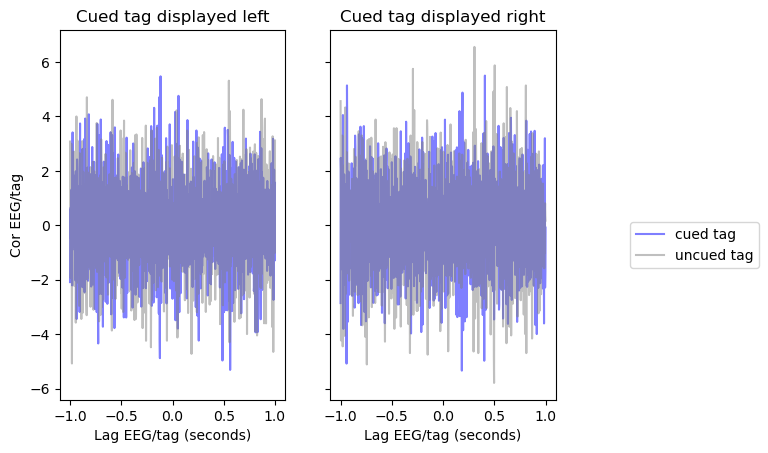

In [28]:
# Compute cross-cor on time-window ?????
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1


cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag, noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = best_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag, noise_stims_tr, 'left', electrodes = best_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise)

# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].plot(times,cor_with_cued_for_cuedL.mean(axis=(0,1)).T, color='blue', alpha=.5)
ax[0].plot(times,cor_with_uncued_for_cuedL.mean(axis=(0,1)).T, color='grey', alpha=.5)

ax[1].plot(times,cor_with_cued_for_cuedR.mean(axis=(0,1)).T, color='blue', label='cued tag', alpha=.5)
ax[1].plot(times,cor_with_uncued_for_cuedR.mean(axis=(0,1)).T, color='grey', label='uncued tag', alpha=.5)


ax[0].set_title('Cued tag displayed left');
ax[1].set_title('Cued tag displayed right');

ax[1].legend(bbox_to_anchor = (1.3,0.5))
ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

### 1.1.1 Comparing pre and post cue crosscorrelation

Test for cued tag and electrode Oz: TtestResult(statistic=-1.0094188051596384, pvalue=0.3141835545581275, df=173)
Test for uncued tag and electrode Oz: TtestResult(statistic=0.6285062753259535, pvalue=0.5305012399352097, df=173)
Test for cued tag and electrode P2: TtestResult(statistic=-1.6850517023362452, pvalue=0.09378161648975783, df=173)
Test for uncued tag and electrode P2: TtestResult(statistic=-0.8719408616801564, pvalue=0.3844491290371015, df=173)
Test for cued tag and electrode P4: TtestResult(statistic=-2.1223036006974607, pvalue=0.03523540173520889, df=173)
Test for uncued tag and electrode P4: TtestResult(statistic=0.6486165555852285, pvalue=0.5174462916513265, df=173)
Test for cued tag and electrode Pz: TtestResult(statistic=-0.08420105376687786, pvalue=0.9329939363290214, df=173)
Test for uncued tag and electrode Pz: TtestResult(statistic=-0.38359255776180634, pvalue=0.7017514497087004, df=173)
Test for cued tag and electrode POz: TtestResult(statistic=0.5626376259445369,

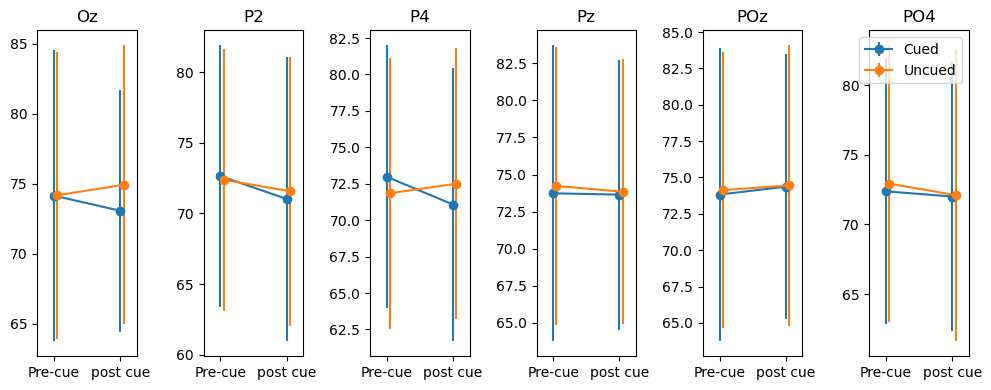

In [29]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

fig, ax = plt.subplots(1,6, figsize=(10,4), sharex=True)
for i, elec in enumerate(best_electrodes):
    max_precue_cued = cor_with_cued[:,i,:cor_with_cued.shape[-1]//2].max(axis=-1)
    max_postcue_cued = cor_with_cued[:,i,cor_with_cued.shape[-1]//2-1:].max(axis=-1)
    ax[i].errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                    yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
    print(f'Test for cued tag and electrode {elec}: {scipy.stats.ttest_rel(max_postcue_cued, max_precue_cued)}')
    max_precue_uncued = cor_with_uncued[:,i,:cor_with_uncued.shape[-1]//2].max(axis=-1)
    max_postcue_uncued = cor_with_uncued[:,i,cor_with_uncued.shape[-1]//2-1:].max(axis=-1)
    
    ax[i].errorbar([0.05,1.05], [np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                    [np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
    print(f'Test for uncued tag and electrode {elec}: {scipy.stats.ttest_rel(max_postcue_uncued,max_precue_uncued)}')
                        
    ax[i].set_xticks([0,1],['Pre-cue', 'post cue'])
    ax[i].set_title(elec)
ax[-1].legend()
plt.xlim(-.25, 1.25)
plt.tight_layout()

Instead of doing it per electrode we can, prior to looking for the max, average across electrodes to improve SNR

Test for cued tag: TtestResult(statistic=-0.023181237374057154, pvalue=0.9815324209612455, df=173)
Test for uncued tag: TtestResult(statistic=0.7985922622431769, pvalue=0.42562182036730023, df=173)


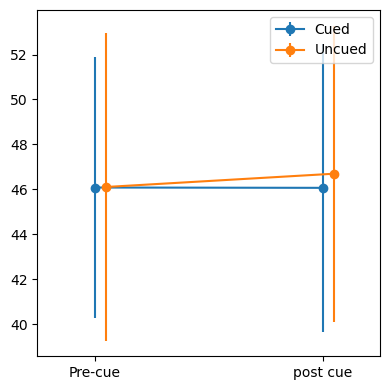

In [30]:
cor_with_cued = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])
cor_with_uncued = np.concatenate([cor_with_uncued_for_cuedR,cor_with_uncued_for_cuedL])

fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)
max_precue_cued = cor_with_cued[:,:,:cor_with_cued.shape[-1]//2].mean(axis=1).max(axis=-1)
max_postcue_cued = cor_with_cued[:,:,cor_with_cued.shape[-1]//2-1:].mean(axis=1).max(axis=-1)
ax.errorbar(x=[0,1], y=[np.mean(max_precue_cued), np.mean(max_postcue_cued)],
                yerr=[np.std(max_precue_cued), np.std(max_postcue_cued)], fmt='o-', label='Cued')
print(f'Test for cued tag: {scipy.stats.ttest_rel(max_postcue_cued, max_precue_cued)}')
max_precue_uncued = cor_with_uncued[:,:,:cor_with_uncued.shape[-1]//2].mean(axis=1).max(axis=-1)
max_postcue_uncued = cor_with_uncued[:,:,cor_with_uncued.shape[-1]//2-1:].mean(axis=1).max(axis=-1)

ax.errorbar([0.05,1.05], [np.mean(max_precue_uncued), np.mean(max_postcue_uncued)],
                [np.std(max_precue_uncued), np.std(max_postcue_uncued)], fmt='o-', label='Uncued')
print(f'Test for uncued tag: {scipy.stats.ttest_rel(max_postcue_uncued,max_precue_uncued)}')
                    
ax.set_xticks([0,1],['Pre-cue', 'post cue'])
ax.legend()
plt.xlim(-.25, 1.25)
plt.tight_layout()

S'il y avait un effet attentionel on attendrait que seulement le cued augmente, s'il n'y a pas d'effet attentionnel mais que les tags sont present on peut attendre que les deux tags augmentent. Si les tags ne sont pas present, le post-cue n'est pas superieur au pre-cue

In [31]:
# Export for group analysis
def prepostcor_todf(corr_arr, time_window, tag_cueing):
    df = pd.DataFrame(corr_arr, columns = ['max_avg_over_ch_crosscor'])
    df['pre/post_cue'] = time_window
    df['cued/uncued_tag'] = tag_cueing
    return df


prepostcue_cor_A0 = pd.concat([prepostcor_todf(max_postcue_cued, 'postcue', 'cued'), prepostcor_todf(max_postcue_uncued, 'postcue', 'uncued'),  \
           prepostcor_todf(max_precue_cued, 'precue', 'cued'), prepostcor_todf(max_precue_uncued, 'precue', 'uncued')    ])

prepostcue_cor_A0.to_csv('files/prepostcue_cor_A0.csv',index=False)


### 1.1.2 Comparing cross-correlation on displayed trial vs others

In [32]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2 # Take up to two seconds to allow for max correlation even after stimulus onset
tmin_noise, tmax_noise = 0, 1

# First for left cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL = np.zeros((2, len(trials), len(trials), len(best_electrodes), tmax_eeg*sfreq+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Give the same trial number as the EEG
    # Perform cross-correlation on the repeated noise and all eeg trials
    crosscorr_trial = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes = best_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    trial_crosscorr_matL[0, trial_idx] = crosscorr_trial[0]
    trial_crosscorr_matL[1, trial_idx] = crosscorr_trial[1]

# For right cued side
trials = epochs_noistag.metadata['trial_number'][epochs_noistag['cued_side == 1'].selection]
trial_crosscorr_matR = np.zeros((2, len(trials), len(trials), len(best_electrodes), tmax_eeg*sfreq+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Give the same trial number as the EEG
    # Perform cross-correlation on the repeated noise and all eeg trials
    crosscorr_trial = cross_cor_nois(epochs_fun = epochs_noistag, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes = best_electrodes,\
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    trial_crosscorr_matR[0, trial_idx] = crosscorr_trial[0]
    trial_crosscorr_matR[1, trial_idx] = crosscorr_trial[1]

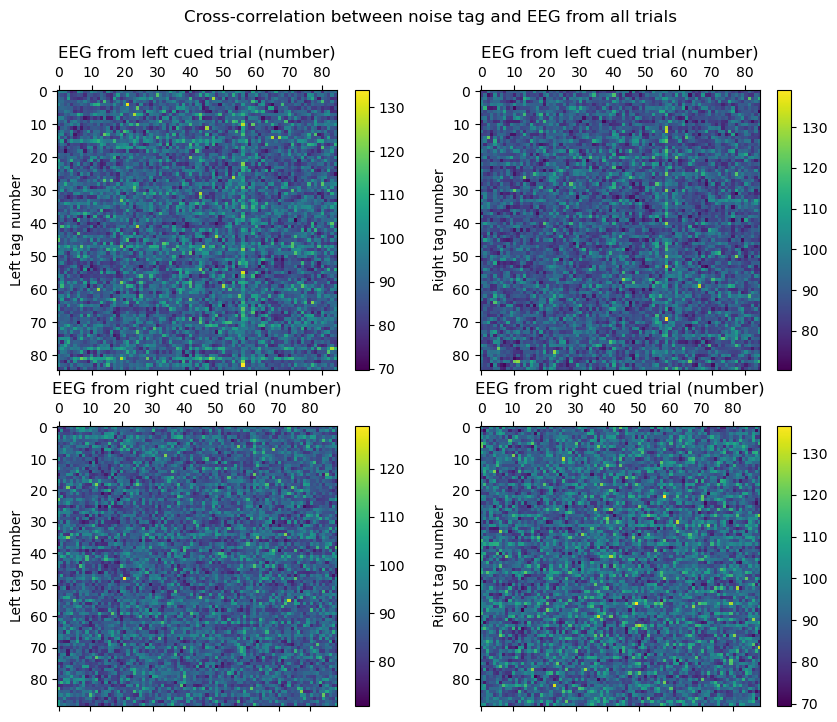

In [33]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
noise1 = ax[0,0].matshow(np.max(trial_crosscorr_matL[0][:,:].max(axis=-1), axis=-1))
fig.colorbar(noise1, ax=ax[0,0])
ax[0,0].set_ylabel('Left tag number')
ax[0,0].set_title('EEG from left cued trial (number)')
noise2 = ax[0,1].matshow(np.max(trial_crosscorr_matL[1][:,:].max(axis=-1), axis=-1))
fig.colorbar(noise2, ax=ax[0,1])
ax[0,1].set_ylabel('Right tag number')
ax[0,1].set_title('EEG from left cued trial (number)')
noise2 = ax[1,0].matshow(np.max(trial_crosscorr_matR[1][:,:].max(axis=-1), axis=-1))
fig.colorbar(noise2, ax=ax[1,1])
ax[1,0].set_ylabel('Left tag number')
ax[1,0].set_title('EEG from right cued trial (number)')
noise1 = ax[1,1].matshow(np.max(trial_crosscorr_matR[0][:,:].max(axis=-1), axis=-1))
fig.colorbar(noise1, ax=ax[1,0])
ax[1,1].set_ylabel('Right tag number')
ax[1,1].set_title('EEG from right cued trial (number)')

plt.suptitle('Cross-correlation between noise tag and EEG from all trials')
plt.show()
